In [1]:
# 匯入相關所需的模組
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from pathlib import PurePath
import cv2

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical

# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 置放資料的路徑
DATA_PATH = os.path.join(ROOT_DIR, "data")

# 置放原始圖像檔案的路徑
ORIGIN_IMG_PATH = os.path.join(DATA_PATH, "origin_imgs")

# 置放要用來訓練用圖像檔案的路徑
TRAIN_IMG_PATH = os.path.join(DATA_PATH, "train")

# 訓練用的圖像大小與色階
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHANNEL = 1

Using TensorFlow backend.


In [2]:
# 取得原始圖像的檔案路徑
all_img_paths = glob.glob(os.path.join(ORIGIN_IMG_PATH, "*.PNG"))

# 進行圖像色階轉換及大小的修改
for img_path in all_img_paths:
    filename = (PurePath(img_path).stem) # 取得原圖像檔案名稱, 例如.c01
    new_filename = filename + ".png" # 更換附檔名    
    card_img_grey = cv2.imread(img_path, 0) # 使用OpenCV以灰階讀入
    card_img = cv2.resize(card_img_grey, (IMG_HEIGHT, IMG_WIDTH)) # 轉換大小  
    cv2.imwrite(os.path.join(TRAIN_IMG_PATH, new_filename), card_img) # 寫出

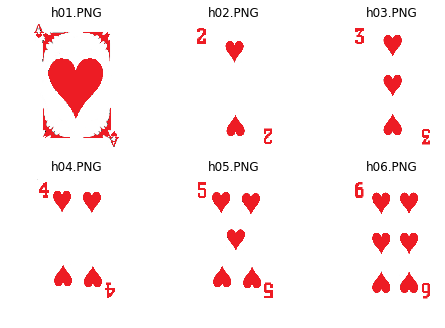

In [3]:
plt.figure(figsize=(8,8)) # 設定每個圖像顯示的大小

# 產生一個3x2網格的組合圖像
for i in range(0, 6):
    img_file = 'h0'+str(i+1)+'.PNG'
    img = cv2.imread(os.path.join(ORIGIN_IMG_PATH, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(330+1+i) # (331) -> 第一個子圖像, (332) -> 第二個子圖像
    plt.title(img_file)  # 秀出原圖像的檔名
    plt.axis('off')      #不顯示坐標
    plt.imshow(img)      # 圖像顯示
    
# 展現出圖像
plt.show()

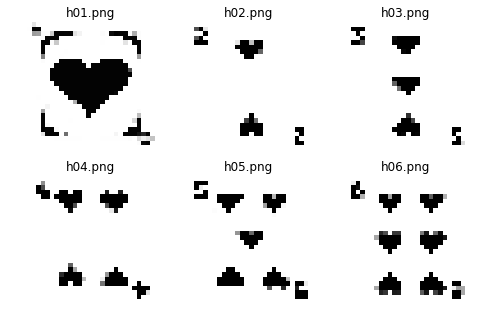

In [4]:
plt.figure(figsize=(8,8)) # 設定每個圖像顯示的大小

# 產生一個3x2網格的組合圖像
for i in range(0, 6):
    img_file = 'h0'+str(i+1)+'.png'
    img = cv2.imread(os.path.join(TRAIN_IMG_PATH, img_file),0)
    
    plt.subplot(330+1+i) # (331) -> 第一個子圖像, (332) -> 第二個子圖像
    plt.title(img_file)  # 秀出原圖像的檔名
    plt.axis('off')      #不顯示坐標
    plt.imshow(img, cmap=plt.get_cmap('gray'))      # 圖像顯示
    
# 展現出圖像
plt.show()

In [5]:
num_classes = 52 # 撲克牌的標籤總共有52類
img_rows, img_cols, img_channels = IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL # 圖像是 49像素 x 33像素 (灰色階: 1)
input_shape = (img_rows, img_cols, img_channels) # (圖像的height, 圖像的width, 圖像的顏色通道數channel)

# 載入標籤資料檔
cards_data = pd.read_excel(os.path.join(DATA_PATH, 'cards_data.xlsx'))

# 取得"card_label"的欄位資料
cards_label = cards_data['card_label']
 
# 產生相關的查找的字典物件
idx_to_label = {k:v for k, v in cards_label.iteritems()}
label_to_idx = {v:k for k, v in cards_label.iteritems()}

# 取得所有圖像的標籤值
y = np.array(cards_label.index.values)

# 進行標籤的one-hot編碼
y_train = to_categorical(y, num_classes)
y_test = y_train.copy()

# 將每個圖像從檔案中讀取進來
imgs = []
all_img_paths = glob.glob(os.path.join(TRAIN_IMG_PATH, "*.png"))

#進行圖像每個像素值的型別轉換與歸一化處理
for img_path in all_img_paths:
    img = cv2.imread(img_path,0) # 以灰階讀入
    img = img.astype('float32')/255.
    imgs.append(img)
    
# 取得要進行訓練用的灰階圖像
X = np.array(imgs)    

# 將圖像數據集的維度進行改變 
# 改變前: [樣本數, 圖像寬, 圖像高] -> 改變後: [樣本數, 圖像寬, 圖像高, 圖像頻道數]
X_train = X.reshape(X.shape[0], 28, 28, 1)
X_test = X_train.copy()

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

X_train: (52, 28, 28, 1)
y_train: (52, 52)


In [6]:
# 產生一個Keras序貫模型
def cnn_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2
                                     )))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model;   

model = cnn_model() # 初始化一個模型
model.summary() # 秀出模型架構

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [7]:
# 讓我們先配置一個常用的組合來作為後續優化的基準點
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

In [8]:
datagen_train = ImageDataGenerator(rotation_range=3.)
datagen_train.fit(X_train)

In [9]:
batch_size = 100
steps_per_epoch = 50000
training_epochs = 700

# 透過data generator來產生訓練資料, 由於資料是可持續產生, 我們可以透過設定'steps_per_epoch'的數量來讓模型可以有更多的訓練批次
history = model.fit_generator(datagen_train.flow(X_train, y_train, batch_size=batch_size),
                            steps_per_epoch= steps_per_epoch,
                            epochs=training_epochs)

Epoch 1/700
25441/50000 [==============>...............] - ETA: 43:30 - loss: 0.0521 - acc: 0.9862

KeyboardInterrupt: 